# NHANES Dataset Part 2

In [2]:
import xgboost
import shap
import numpy as np
import pandas as pd
import scipy.stats as stats
import copy
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 500)
shap.initjs()

In [4]:
X,y = shap.datasets.nhanesi()
X_display,y_display = shap.datasets.nhanesi(display=True)
X.drop(labels='Unnamed: 0', axis=1, inplace=True)
X_display.drop(labels='Unnamed: 0', axis=1, inplace=True)
X["Race"] = [1.0 if v == 1.0 else 0.0 for v in X["Race"]]
X_display["Race"] = ["White" if v == 1.0 else "Other" for v in X_display["Race"]]
X["Sex"] = [1.0 if v == 1.0 else 0.0 for v in X["Sex"]]
X.rename(columns = {'Diastolic BP':'Diastolic Blood Pressure', 'Poverty index':'Poverty Index', 
                    'Red blood cells':'Red Blood Cells', 'Sedimentation rate':'Sedimentation Rate', 
                    'Serum Albumin':'Blood Albumin', 'Serum Cholesterol':'Blood Cholesterol', 'Serum Iron':'Blood Iron', 
                    'Serum Magnesium':'Blood Magnesium', 'Serum Protein':'Blood Protein', 
                    'Systolic BP':'Systolic Blood Pressure', 'TIBC':'Total Iron Binding Capacity', 
                    'TS':'Transferrin Saturation', 'White blood cells':'White Blood Cells', 
                    'Pulse pressure':'Pulse Pressure'}, inplace = True)
params = {
    "eta": 0.002,
    "max_depth": 3,
    "objective": "survival:cox",
    "subsample": 0.5
}
xgb_train = xgboost.DMatrix(X, label=y)
model = xgboost.train(params, xgb_train, 10000)
explainer = shap.Explainer(model, X)
shap_values = explainer(X)
shap_values.display_data = X_display.values

100%|===================| 9915/9932 [08:27<00:00]        

This dataset is derived from the NHANES I dataset. It was collected by the Center for Disease Control and Prevention from 1971-1974. It is used to predict how soon each individual will die compared to the other individuals in the dataset after their initial screening between 1971 and 1974.   
  
Task: Regression using a Cox survival model   
Outcome Variable: The total number of years the individual lived for after their initial screening  
Input Features:
- Age: a continuous variable
- Diastolic Blood Pressure: a continuous variable of the bottom number in a blood pressure reading and is involved in hypertension. Normal range is 60-80.
- Poverty Index: a continuous variable of the ratio between family income to poverty guidelines. Smaller values mean higher poverty levels.
- Race: a binary variable for the individual's race. 1 encodes white, 0 encodes anything other than white.
- Red Blood Cells: a continuous variable and is involved in transporting oxygen within the blood. Normal range is 40-55. 
- Sedimentation Rate: a continuous variable and is involved in inflammation. Normal range is 0-29.
- Blood Albumin: a continuous variable and is involved in kidney and liver function. Normal range is 3.5-5.5.
- Blood Cholesterol: a continuous variable and is involved in heart disease. Normal is below 200.
- Blood Iron: a continuous variable and is involved in making red blood cells. Normal range is 50-170.
- Blood Magnesium: a continuous variable and is involved in muscle function. Normal range is 1.7-2.2.
- Blood Protein: a continuous variable and is involved in general transport of things within the blood. It includes albumin and globulin. Normal range is 6.0-8.5.
- Sex: a binary variable for the individual's sex. 1 encodes male, 0 encodes female.
- Systolic Blood Pressure: a continuous variable of the top number in a blood pressure reading and is involved in hypertension. Normal range is 90-120.
- Total Iron Binding Capacity: a continuous variable and is involved in how well iron circulates in blood. Normal range is 240-450.
- Transferrin Saturation: a continuous variable of blood iron divided by total iron binding capacity. Normal range is 20-45.
- White Blood Cells: a continuous variable and is involved in immune response. Normal range is 3.5-9.5. 
- BMI: a continuous variable of an individual's weight to height ratio. Normal range is 18.5-25.
- Pulse Pressure: a continuous variable of systolic blood pressure minus diastolic blood pressure. Normal range is 40-60.
  
Using this dataset, we built a gradient boosted tree model that predicts when an individual will die, measured in number of years after the individual's first screening. We then explain this model's output using SHAP.

In [5]:
X.describe()

,Age,Diastolic Blood Pressure,Poverty Index,Race,Red Blood Cells,Sedimentation Rate,Blood Albumin,Blood Cholesterol,Blood Iron,Blood Magnesium,Blood Protein,Sex,Systolic Blood Pressure,Total Iron Binding Capacity,Transferrin Saturation,White Blood Cells,BMI,Pulse Pressure
count,9932.000000,9874.000000,9932.000000,9932.000000,9932.000000,9106.000000,9932.000000,9932.000000,9932.000000,9932.000000,9932.000000,9932.000000,9875.000000,9932.000000,9932.000000,8891.000000,9932.000000,9873.000000
mean,49.449054,83.281953,287.213049,0.814640,54.880528,16.268285,4.365103,221.234837,101.117298,1.681307,7.104068,0.392771,134.854481,362.604511,28.555910,7.451760,25.689771,51.575509
std,15.878425,13.291925,223.310410,0.388609,14.600767,11.511728,0.331212,49.494473,37.211666,0.145905,0.508969,0.488391,24.932032,58.993649,11.232671,2.292071,5.184155,18.299075
min,25.000000,25.000000,2.000000,0.000000,21.400000,1.000000,2.700000,53.000000,17.000000,0.820000,4.400000,0.000000,80.000000,112.000000,3.200000,2.100000,12.585333,10.000000
25%,35.000000,74.000000,130.000000,1.000000,45.000000,7.000000,4.200000,187.000000,75.000000,1.590000,6.800000,0.000000,118.000000,322.000000,21.000000,6.000000,22.108338,40.000000
50%,48.000000,82.000000,233.000000,1.000000,48.900000,14.000000,4.400000,217.000000,96.000000,1.680000,7.100000,0.000000,130.000000,356.000000,27.200000,7.200000,24.928952,48.000000
75%,66.000000,90.000000,372.000000,1.000000,57.600000,22.000000,4.600000,250.000000,122.000000,1.770000,7.400000,1.000000,150.000000,396.000000,34.600000,8.600000,28.369043,60.000000
max,74.000000,180.000000,999.000000,1.000000,88.800000,72.000000,5.700000,793.000000,396.000000,2.890000,11.500000,1.000000,270.000000,717.000000,100.000000,56.000000,72.218113,170.000000


# Global Feature Importance Bar Plots

### Mean Absolute Value

**How it's Calculated:** Mean over all samples in the training data set of the absolute value of each sample's model attribution score.  
**Potential Uses:** Gives a sense of what the model is learning overall. Currently the default global feature importance ranking in SHAP.

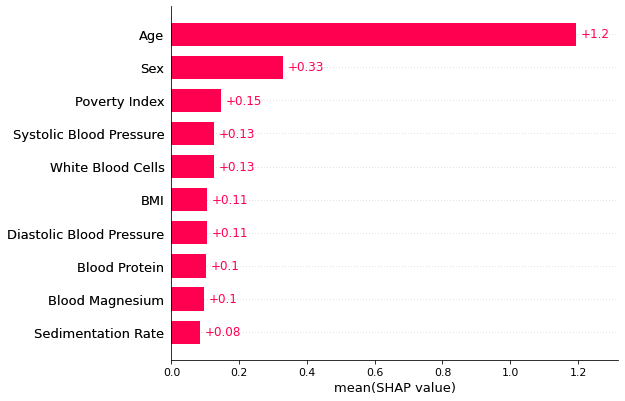

In [6]:
shap.plots.bar(shap_values)

### Range

**How it's Calculated:** Difference between the maximum model attribution score and the minimum model attribution score of the given feature over the training data set.   
**Potential Uses:** Identifies features that are heavily influential on at least a small number of samples in the data. Can also help find extreme outliers in the data.

<function matplotlib.pyplot.show(*args, **kw)>

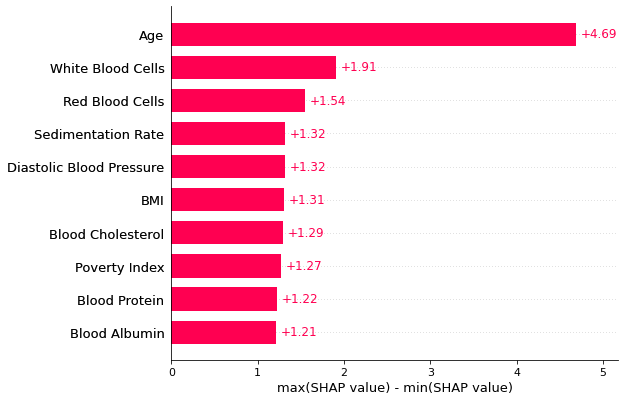

In [7]:
shap_values_max = copy.deepcopy(shap_values)
shap_values_max.values = [shap_values_max.max(0).values - shap_values_max.min(0).values]
shap.plots.bar(shap_values_max[0], show=False)
plt.xlabel('max(SHAP value) - min(SHAP value)')
plt.show

### Typical Range (Excluding Outliers)

**How it's Calculated:** Difference between the 95th percentile model attribution score and the 5th percentile model attribution score of the given feature over the training data set.  
**Potential Uses:** Identifies features that are heavily influential for at least a substantial subset of samples within the data. More robust to outliers than the Range. Can also help find subsets within the data.

<function matplotlib.pyplot.show(*args, **kw)>

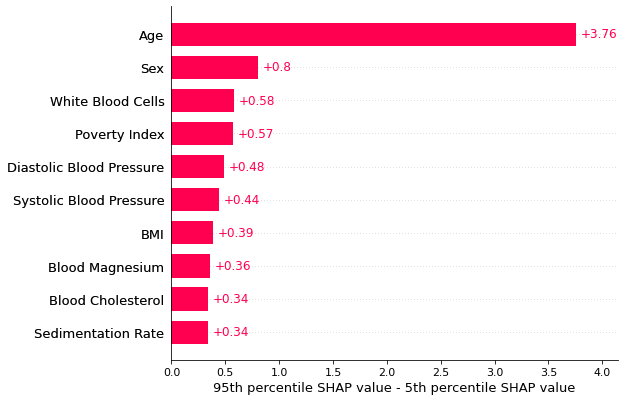

In [8]:
percentile_num = 95
shap_values_percent = copy.deepcopy(shap_values)
shap_values_percent.values = [shap_values_percent.percentile(percentile_num, 0).values - shap_values_percent.percentile(100-percentile_num, 0).values]
shap.plots.bar(shap_values_percent[0], show=False)
plt.xlabel('95th percentile SHAP value - 5th percentile SHAP value')
plt.show

### Frequency in Top 3

**How it's Calculated:** Fraction of samples in the training data set for which the given feature was ranked in the top three in terms of absolute attribution scores.   
**Potential Uses:** Gives a sense of which features most commonly have heavy influence on individual samples' predictions. Can also help to get an understanding without needing to understand the model attribution score.

<function matplotlib.pyplot.show(*args, **kw)>

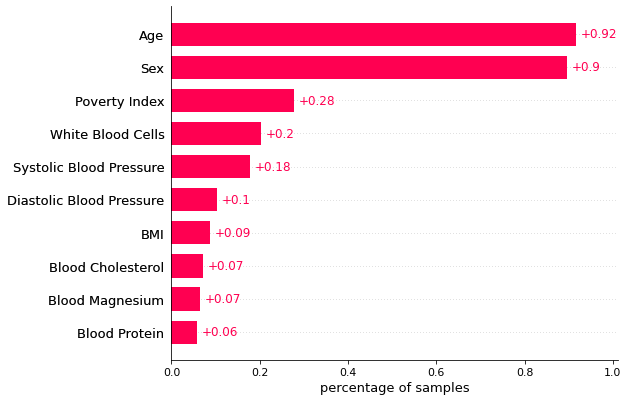

In [9]:
rank_num = 3
shap_values_rank = copy.deepcopy(shap_values)
shap_values_rank.values = (np.absolute(shap_values_rank.values).argsort(1)).argsort(1)
shap_values_rank.values = shap_values_rank.values-(shap_values_rank.values.shape[1]-rank_num-1)
shap_values_rank.values[shap_values_rank.values < 0] = 0
shap_values_rank.values[shap_values_rank.values > 0] = 1
shap.plots.bar(shap_values_rank, show=False)
plt.xlabel('percentage of samples')
plt.show

# Global Feature Importance Summary Plot

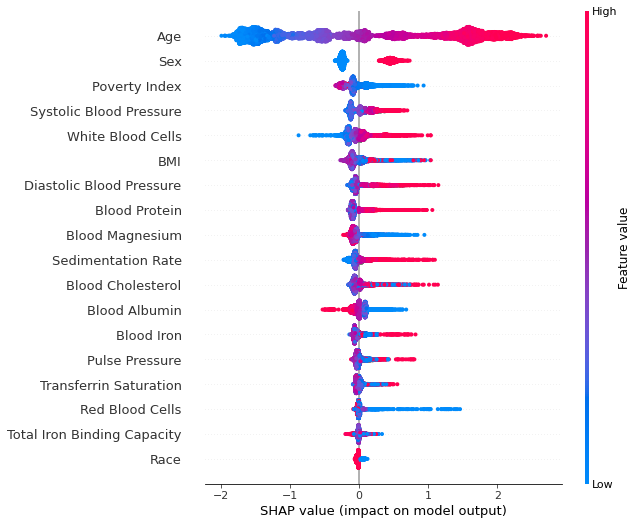

In [10]:
shap.plots.beeswarm(shap_values)

# Individual Feature Dependence Plots

#### Age

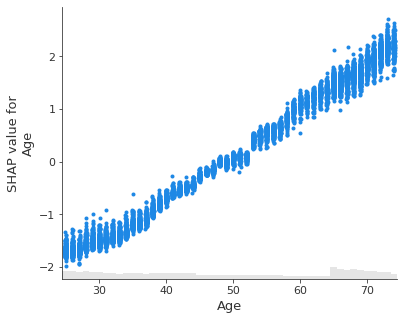

In [11]:
shap.plots.scatter(shap_values[:,'Age'])

#### Blood Albumin

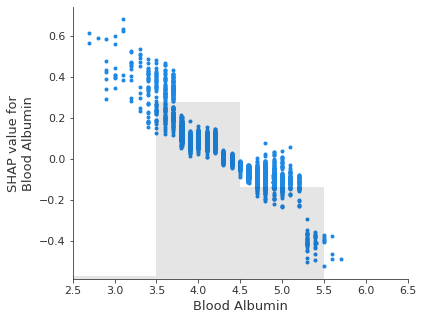

In [17]:
shap.plots.scatter(shap_values[:,'Blood Albumin'])

#### Blood Cholesterol

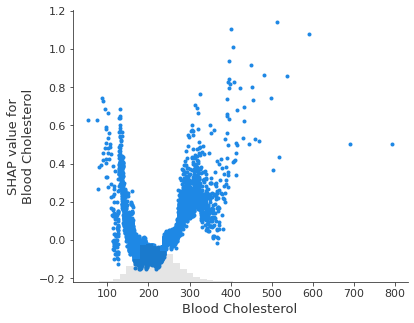

In [18]:
shap.plots.scatter(shap_values[:,'Blood Cholesterol'])

#### Blood Iron

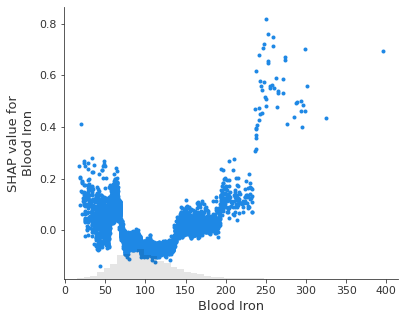

In [19]:
shap.plots.scatter(shap_values[:,'Blood Iron'])

#### Blood Magnesium

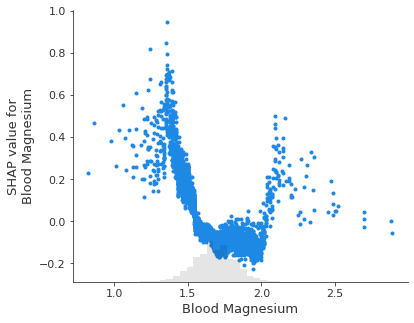

In [20]:
shap.plots.scatter(shap_values[:,'Blood Magnesium'])

#### Blood Protein

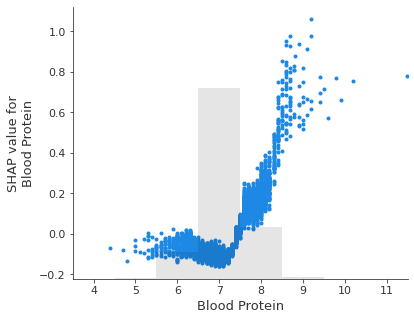

In [21]:
shap.plots.scatter(shap_values[:,'Blood Protein'])

#### BMI

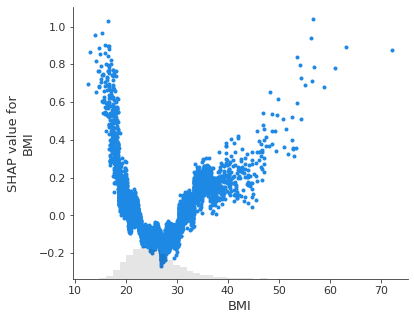

In [27]:
shap.plots.scatter(shap_values[:,'BMI'])

#### Diastolic Blood Pressure

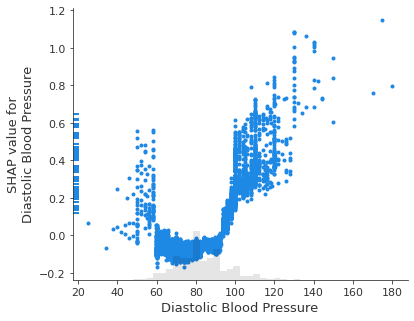

In [12]:
shap.plots.scatter(shap_values[:,'Diastolic Blood Pressure'])

#### Poverty Index

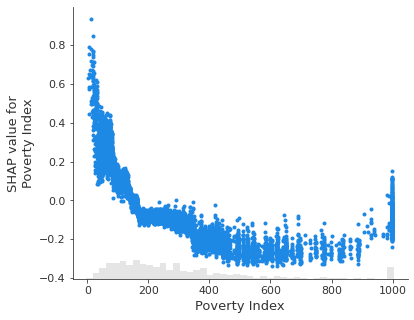

In [13]:
shap.plots.scatter(shap_values[:,'Poverty Index'])

#### Pulse Pressure

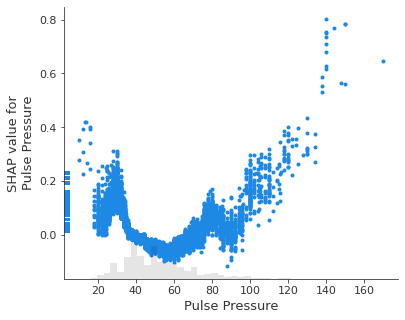

In [28]:
shap.plots.scatter(shap_values[:,'Pulse Pressure'])

#### Race

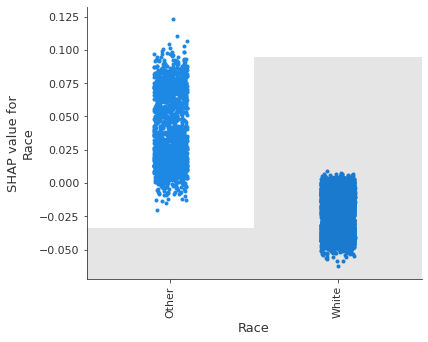

In [14]:
shap.plots.scatter(shap_values[:,'Race'])

#### Red Blood Cells

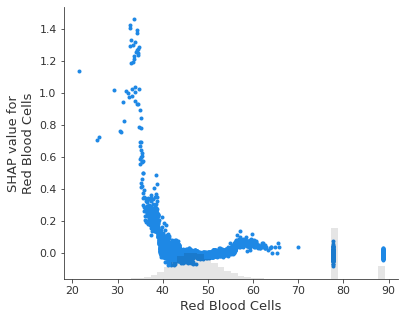

In [15]:
shap.plots.scatter(shap_values[:,'Red Blood Cells'])

#### Sedimentation Rate

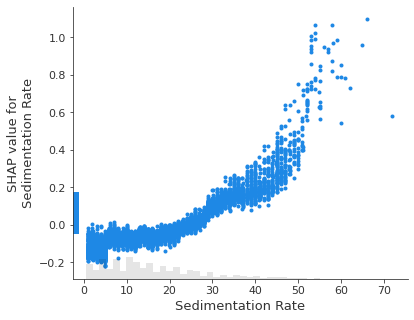

In [16]:
shap.plots.scatter(shap_values[:,'Sedimentation Rate'])

#### Sex

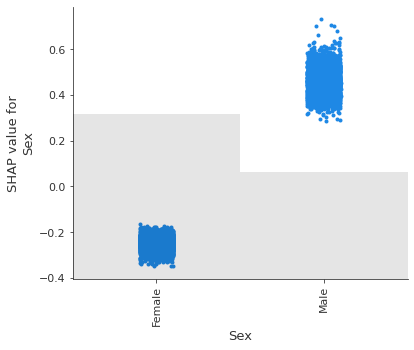

In [22]:
shap.plots.scatter(shap_values[:,'Sex'])

#### Systolic Blood Pressure

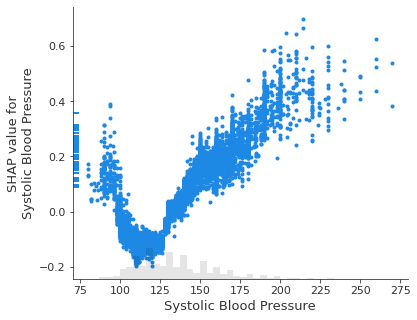

In [23]:
shap.plots.scatter(shap_values[:,'Systolic Blood Pressure'])

#### Total Iron Binding Capacity

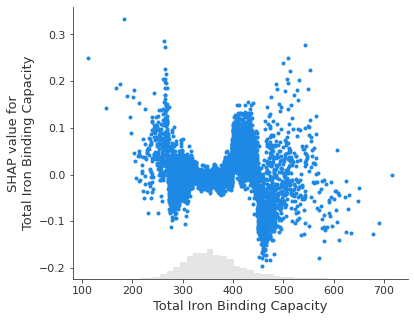

In [24]:
shap.plots.scatter(shap_values[:,'Total Iron Binding Capacity'])

#### Transferrin Saturation

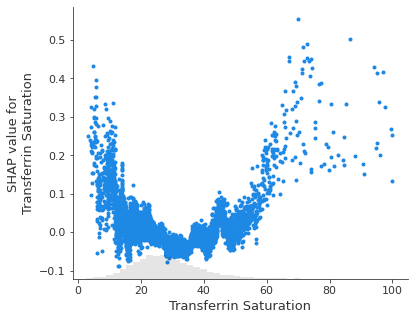

In [25]:
shap.plots.scatter(shap_values[:,'Transferrin Saturation'])

#### White Blood Cells

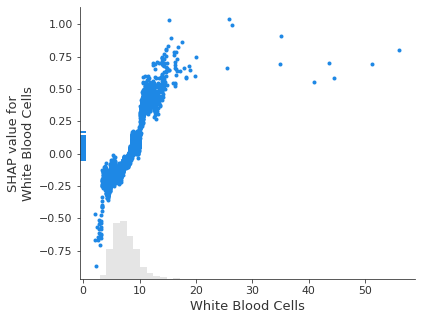

In [26]:
shap.plots.scatter(shap_values[:,'White Blood Cells'])